**Dataset**
labeled dataset collected from twitter (Hate Speech.tsv)

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

**Steps**

To classify hate speech in tweets, follow these key steps:

1. **Data Preprocessing**: Clean text (remove punctuation, stopwords, etc.), lowercase, tokenize, and so on.
2. **Text Representation**: Use Bag of Words, TF-IDF, or word embeddings (e.g., GloVe, Word2Vec, or FastText).
3. **Modeling Approaches**:
   - **Traditional Models**: Logistic Regression, Naive Bayes, SVM, Random Forest.
   - **Deep Learning**: LSTM or RNN.
4. **Evaluation**
5. **Optimization**: Use hyperparameter tuning, regularization, and ensemble methods for better performance.


### Import used libraries

In [175]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tqdm import tqdm
from ftfy import fix_text
import emoji
import contractions
from wordsegment import load, segment
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# NLTK downloads (run once)
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Load word segmentation model
load()

# Pandas settings for better display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

# Check for GPU availability with PyTorch
import torch
torch.cuda.is_available()


False

### Load Dataset

###### Note: search how to load the data from tsv file

In [176]:
df = pd.read_csv("Hate Speech.tsv", sep="\t", encoding='utf-8')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31535 entries, 0 to 31534
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31535 non-null  int64 
 1   label   31535 non-null  int64 
 2   tweet   31535 non-null  object
dtypes: int64(2), object(1)
memory usage: 739.2+ KB


Text(0.5, 1.0, 'Label Distribution Across Dataset')

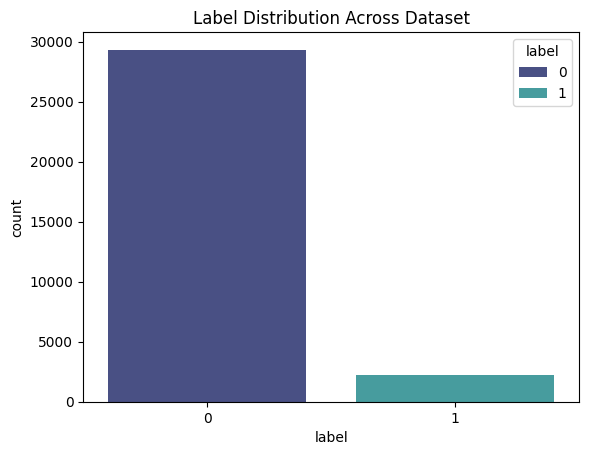

In [178]:
sns.countplot(data=df, x='label', palette='mako',hue='label').set_title('Label Distribution Across Dataset')

In [179]:
# Length of word in sentence
data = df.copy() 
data['Length'] = data['tweet'].apply(lambda r: len(r.split(" ")))
data.head()

,id,label,tweet,Length
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,20
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,22
2,3,0,bihday your majesty,3
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,15
4,5,0,factsguide: society now #motivation,7


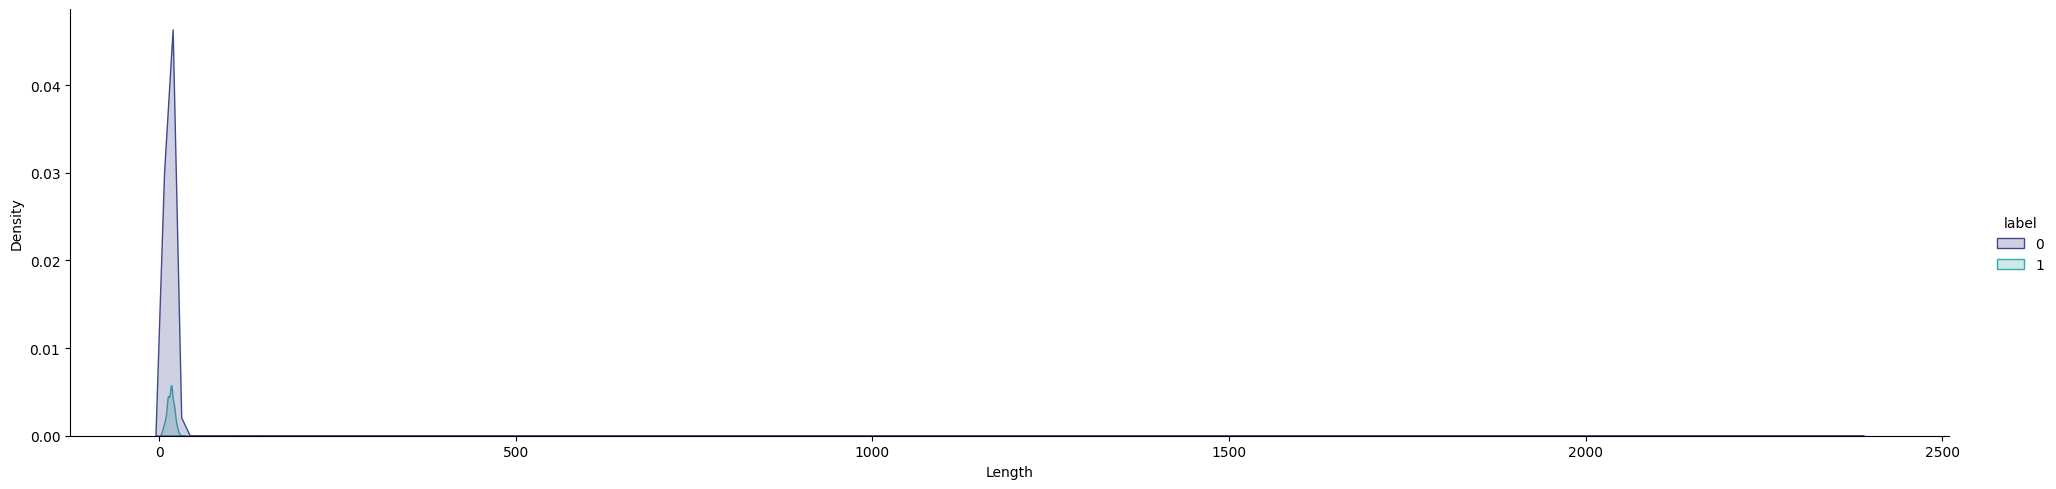

In [180]:
sns.displot(data=data, x='Length', hue='label', palette='mako', kind='kde', fill=True, aspect=4)

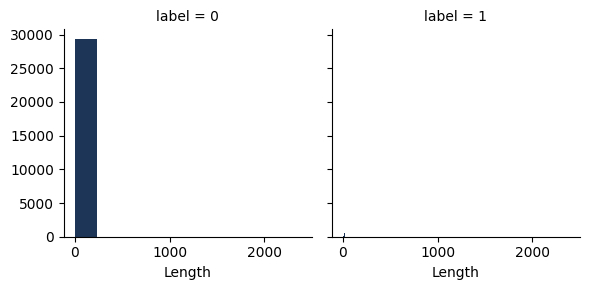

In [181]:
g = sns.FacetGrid(data=data, col='label')
g.map(plt.hist, 'Length', color='#1D3557')

<Axes: xlabel='label', ylabel='Length'>

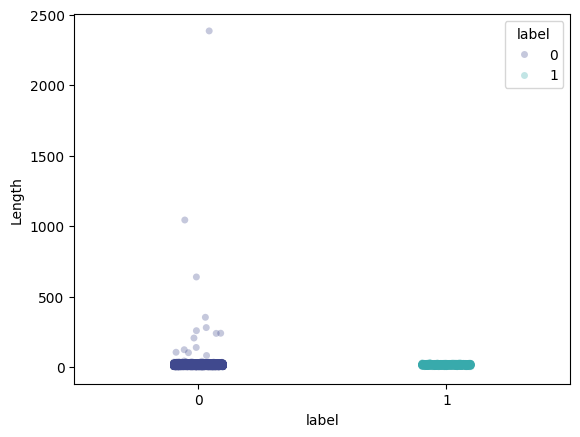

In [182]:
sns.stripplot(data=data, x='label', y='Length', palette='mako', alpha=0.3, hue='label')

### Data splitting

It is a good practice to split the data before EDA helps maintain the integrity of the machine learning process, prevents data leakage, simulates real-world scenarios more accurately, and ensures reliable model performance evaluation on unseen data.

In [183]:
# Split into train+val and test sets
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['label']
)

""" Thought of making another split to the train set to be train and validation"""
# Split train+val into train and val sets
# train_df, val_df = train_test_split(
#     train_val_df, test_size=0.2 / 0.8, random_state=42, stratify=train_val_df['label']
# )

print(f"Training set size: {train_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Training set size: 22074
Test set size: 9461


### EDA on training data

- check NaNs

In [184]:
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

- check duplicates

In [185]:
# Identify duplicate rows
duplicate_rows = train_df[train_df.duplicated()]

num_duplicates = duplicate_rows.shape[0]
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


- show a representative sample of data texts to find out required preprocessing steps

In [186]:
# Display a random sample of tweets
sample_texts = train_df['tweet'].sample(20, random_state=42)

for idx, text in sample_texts.items():
    print(f"Sample {idx}:\n{text}\n")


Sample 20412:
best #essentialoils for #weightloss!!   #altwaystoheal #healthy is  !!

Sample 18941:
â #eur/usd limited upside risk in near-term Â - scotiabank   #blog #silver #gold #forex

Sample 22321:
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦

Sample 4961:
â #em: global liquidity outlook has turned back in favor of em fx - bbh   #blog #silver #gold #forex

Sample 8700:
#body to body massage with a   ending oil #massage ,body happyending massage center abu dhabi ,0506823156 

Sample 2899:
#lalienmorfi  @user greciaaaa

Sample 5837:
if i was an actual fruit, i'd be a raspberry.  cuz in france i'd be a framboise.    #pride #yall

Sample 22650:
on our way to nashville!   #musicislife

Sample 31373:
 @user 9902  , #education, #smilingbutimclosetotears   hows your week been... 

Sample 15125:
mex wins the group! :) ð²ð½â½ï¸  #eltri

Sample 15491:
oops! #carlpaladino didn't mean to publicly post  comments...  via @user

Sample 11347:
#mal

* Adding length of each tweet

In [187]:
train_df.head()

,id,label,tweet
20850,21261,0,"paradise is not a place, it's a state of mind @user â¤ï¸ðâ¨ #grateful #peace #soul #passion"
15384,15773,0,@user @user seeing them just put me in a really good mood. thanks. #jbell #thehumancondition #gotmelike
13801,14155,0,i never got my follow from @user
30644,31072,0,i am thankful for being able to walk.#thankful #positive
26975,27403,0,hour #djgeezð§ #downtownphilly


In [188]:
# Length of word in sentence
train_df['Length'] = train_df['tweet'].apply(lambda r: len(r.split(" ")))
train_df.head()

,id,label,tweet,Length
20850,21261,0,"paradise is not a place, it's a state of mind @user â¤ï¸ðâ¨ #grateful #peace #soul #passion",19
15384,15773,0,@user @user seeing them just put me in a really good mood. thanks. #jbell #thehumancondition #gotmelike,17
13801,14155,0,i never got my follow from @user,7
30644,31072,0,i am thankful for being able to walk.#thankful #positive,9
26975,27403,0,hour #djgeezð§ #downtownphilly,3


In [189]:
train_df.shape[0]

22074

### Dropping tweets with large length

In [190]:
train_df = train_df[train_df['tweet'].str.len() <= 280]

In [191]:
train_df.shape[0]

22064

In [192]:
if 'Length' in train_df.columns:
    train_df = train_df.drop(columns=['Length'])


train_df.head()

,id,label,tweet
20850,21261,0,"paradise is not a place, it's a state of mind @user â¤ï¸ðâ¨ #grateful #peace #soul #passion"
15384,15773,0,@user @user seeing them just put me in a really good mood. thanks. #jbell #thehumancondition #gotmelike
13801,14155,0,i never got my follow from @user
30644,31072,0,i am thankful for being able to walk.#thankful #positive
26975,27403,0,hour #djgeezð§ #downtownphilly


- check dataset balancing

In [193]:
# Calculate the count of each class and show the percentage
class_counts = train_df['label'].value_counts()

print("Class Counts:")
print(class_counts)

class_percentages = train_df['label'].value_counts(normalize=True) * 100

print("\nClass Percentages:")
print(class_percentages)


Class Counts:
label
0    20515
1     1549
Name: count, dtype: int64

Class Percentages:
label
0    92.979514
1     7.020486
Name: proportion, dtype: float64


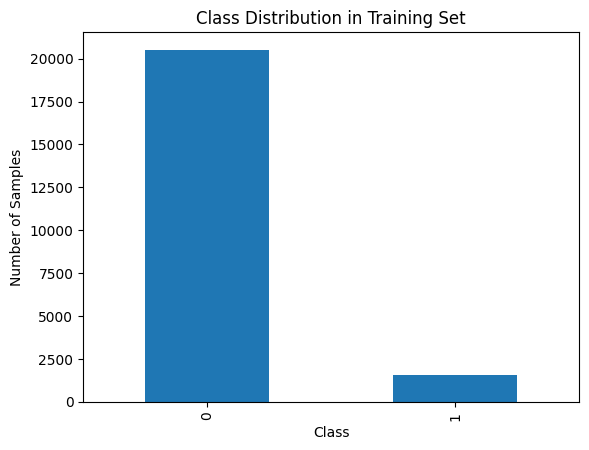

In [194]:
# Plot class distribution
class_counts.plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


### Let's down sample the data a bit so we can preprocess it easily without consuming much time

In [195]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train_df[train_df['label'] == 0]
df_minority = train_df[train_df['label'] == 1]

# Downsample majority class
df_majority_downsampled = resample(
    df_majority, 
    replace=False, 
    n_samples=len(df_minority),
    random_state=42   
)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)



In [196]:
df_downsampled.head()

,id,label,tweet
0,26603,1,"@user have you joined the pizza pay? we're talking #pizzagate, #starwarsrogueoneÂ , the #altright, and ."
1,16127,0,i'm very #iloveyou my #mother and #mama #maria #god #blessâ¦
2,26448,1,(advanced value chain videos at ) #valuechain
3,22530,1,@user are you so bitter because you're a #minoritypresident who lost the people by 3 million? #maga #impeachtrump
4,7496,1,(only) black lives matter also closely affiliated with and suppoed by workers world pay and other communist orgâ¦


Class Counts:
label
1    1549
0    1549
Name: count, dtype: int64

Class Percentages:
label
1    50.0
0    50.0
Name: proportion, dtype: float64


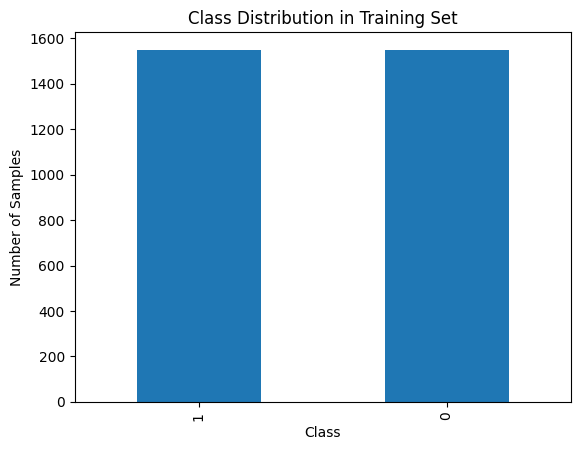

In [197]:
# Calculate the count of each class
class_counts = df_downsampled['label'].value_counts()

# Display the counts
print("Class Counts:")
print(class_counts)

# Calculate the percentage of each class
class_percentages = df_downsampled['label'].value_counts(normalize=True) * 100

# Display the percentages
print("\nClass Percentages:")
print(class_percentages)


import matplotlib.pyplot as plt

# Plot class distribution
class_counts.plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


### Tried sampling but it was way too small and tried to make it the minority class a 30% but still reduced the data samples a lot

In [198]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train_df[train_df['label'] == 0]
df_minority = train_df[train_df['label'] == 1]

# Calculate the desired number of majority samples for 70:30 ratio
desired_majority_samples = int(len(df_minority) * (80/20))

print(f"Desired majority samples: {desired_majority_samples}")
print(f"Current minority samples: {len(df_minority)}")


Desired majority samples: 6196
Current minority samples: 1549


## The dataset is not balanced

- Cleaning and Preprocessing are:
    - check the TextProcessor Class

### Cleaning and Preprocessing

#### Use custom scikit-learn Transformers

Using custom transformers in scikit-learn provides flexibility, reusability, and control over the data transformation process, allowing you to seamlessly integrate with scikit-learn's pipelines, enabling you to combine multiple preprocessing steps and modeling into a single workflow. This makes your code more modular, readable, and easier to maintain.

##### link: https://www.andrewvillazon.com/custom-scikit-learn-transformers/

#### Example usage:

In [199]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, parameter1, parameter2):
        self.parameter1 = parameter1
        self.parameter2 = parameter2
        
        # Add any initialization code here
    
    def fit(self, X, y=None):
        # Add code for fitting the transformer here
        return X
    
    def transform(self, X):
        # Add code for transforming the data here
        transformed_X = X.copy()  # Example: Just copying the data
        
        # Example transformation
        transformed_X['feature1'] = transformed_X['feature1'] * self.parameter1
        transformed_X['feature2'] = transformed_X['feature2'] * self.parameter2
        
        # Do all the needed transformations and data preprocessing here
        
        return transformed_X
    
    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        self.fit(X, y)
        return self.transform(X)

### More Advanced Processing but Time Consuming

In [200]:
# stop_words = set(stopwords.words('english'))
# # custom_stopwords = stop_words - {'but', 'being'}
# lemmatizer = WordNetLemmatizer()
# spell = SpellChecker()
# load()  # Load wordsegment data
# nlp = spacy.load('en_core_web_sm')

# def fix_encoding(text):
#     return fix_text(text)

# def split_hashtags(text):
#     hashtags = re.findall(r'#\w+', text)
#     for tag in hashtags:
#         tag_clean = tag[1:]  # Remove '#' symbol
#         # Use wordsegment to split the hashtag
#         split_words = segment(tag_clean)
#         split_words = ' '.join(split_words)
#         text = text.replace(tag, split_words)
#     return text

# def correct_spelling(text):
#     doc = nlp(text)
#     corrected_words = []
#     for token in doc:
#         word = token.text
#         # Skip proper nouns, abbreviations, long words, and words already in the dictionary
#         if token.ent_type_ or len(word) <= 2 or len(word) > 15 or word.lower() in spell:
#             corrected_words.append(word)
#         else:
#             corrected_word = spell.correction(word)
#             corrected_words.append(corrected_word or word)
#     return corrected_words

# def preprocess_text_hate(text):
#     text = fix_encoding(text)
#     text = emoji.demojize(text)
#     text = text.replace(":", "").replace("_", " ")
#     text = re.sub(r'@\w+', '', text)
#     text = re.sub(r'http\S+|www\S+|https\S+|…', '', text)
#     text = text.lower()
#     text = split_hashtags(text)
#     text = contractions.fix(text)
#     text = text.translate(str.maketrans('', '', string.punctuation))
#     text = ' '.join(correct_spelling(text))
#     words = word_tokenize(text)
#     words = [word for word in words if word not in stop_words]
#     words = [lemmatizer.lemmatize(word) for word in words]
#     preprocessed_text = ' '.join(words)
#     return preprocessed_text

# sample_text_index = random.randint(1, len(train_df) - 1)
# sample_text = train_df['tweet'].iloc[sample_text_index]

# # sample_text = train_df['tweet'].iloc[14285]


# print(sample_text_index)
# processed_text = preprocess_text_hate(sample_text)
# print("Before Processing:")
# print(sample_text)
# print("\nAfter Processing Text:")
# print(processed_text)


### Less Time code

In [206]:
# Initialize necessary components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
load()

def fix_encoding(text):
    return fix_text(text)

def split_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    for tag in hashtags:
        tag_clean = tag[1:]
        split_words = segment(tag_clean)
        split_words = ' '.join(split_words)
        text = text.replace(tag, split_words)
    return text


def preprocess_text(text):
    text = fix_encoding(text)
    text = emoji.demojize(text)
    text = text.replace(":", "").replace("_", " ")
    text = re.sub(r'@\w+', '', text) 
    text = re.sub(r'http\S+|www\S+|https\S+|…', '', text)
    text = text.lower()
    text = split_hashtags(text)
    text = contractions.fix(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = ' '.join(words)
    return preprocessed_text


sample_text_index = random.randint(1, len(train_df) - 1)
sample_text = train_df['tweet'].iloc[sample_text_index]

print(sample_text_index)
processed_text = preprocess_text(sample_text)
print("Before Processing:")
print(sample_text)
print("\nAfter Processing Text:")
print(processed_text)


13119
Before Processing:
have a good day ! #friday   #paris

After Processing Text:
good day friday paris


### Add lenght of each tweet and apply the processing technique to the tweets

In [202]:
from tqdm import tqdm
tqdm.pandas()
sample_df = train_df.copy()
sample_df['Length'] = sample_df['tweet'].apply(lambda r: len(r.split(" ")))
sample_df['Cleaned_tweet'] = sample_df['tweet'].progress_apply(preprocess_text)
sample_df.head()

100%|██████████| 22064/22064 [00:18<00:00, 1209.37it/s]


,id,label,tweet,Length,Cleaned_tweet
20850,21261,0,"paradise is not a place, it's a state of mind @user â¤ï¸ðâ¨ #grateful #peace #soul #passion",19,paradise place state mind red heartfolded handssparkles grateful peace soul passion
15384,15773,0,@user @user seeing them just put me in a really good mood. thanks. #jbell #thehumancondition #gotmelike,17,seeing put really good mood thanks j bell human condition got like
13801,14155,0,i never got my follow from @user,7,never got follow
30644,31072,0,i am thankful for being able to walk.#thankful #positive,9,thankful able walkthankful positive
26975,27403,0,hour #djgeezð§ #downtownphilly,3,hour dj geez headphone downtown philly


### Add the new length of the cleaned tweet

In [207]:
# Length of word in sentence
sample_df['Length_cleaned_tweet'] = sample_df['Cleaned_tweet'].apply(lambda r: len(r.split(" ")))
sample_df.head()

,id,label,tweet,Length,Cleaned_tweet,Length_cleaned_tweet
20850,21261,0,"paradise is not a place, it's a state of mind @user â¤ï¸ðâ¨ #grateful #peace #soul #passion",19,paradise place state mind red heartfolded handssparkles grateful peace soul passion,11
15384,15773,0,@user @user seeing them just put me in a really good mood. thanks. #jbell #thehumancondition #gotmelike,17,seeing put really good mood thanks j bell human condition got like,12
13801,14155,0,i never got my follow from @user,7,never got follow,3
30644,31072,0,i am thankful for being able to walk.#thankful #positive,9,thankful able walkthankful positive,4
26975,27403,0,hour #djgeezð§ #downtownphilly,3,hour dj geez headphone downtown philly,6


### Formed the first part of the pipeline after ensuring the success of preprocess_text func

In [208]:
from tqdm import tqdm
tqdm.pandas()
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_column='tweet', remove_stopwords=True, lemmatize=True):
        self.text_column = text_column
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        
        # Initialize components
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        load()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.text_column not in X.columns:
            raise ValueError(f"Column '{self.text_column}' not found in input DataFrame.")
        
        X_transformed = X.copy()
        X_transformed[self.text_column] = X_transformed[self.text_column].astype(str).progress_apply(self.preprocess_text)
    
        return X_transformed
    
    def preprocess_text(self, text):
        text = self.fix_encoding(text)
        text = self.demojize_text(text)
        text = self.remove_mentions_and_urls(text)
        text = self.lowercase_text(text)
        text = self.split_hashtags(text)
        text = self.expand_contractions(text)
        text = self.remove_punctuation(text)
        text = self.remove_stopwords_and_lemmatize(text)
        return text
    
    def fix_encoding(self, text):
        return fix_text(text)
    
    def demojize_text(self, text):
        text = emoji.demojize(text)
        text = text.replace(":", "").replace("_", " ")
        return text
    
    def remove_mentions_and_urls(self, text):
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        text = re.sub(r'http\S+|www\S+|https\S+|…', '', text)  # Remove URLs and ellipses
        return text
    
    def lowercase_text(self, text):
        return text.lower()
    
    def split_hashtags(self, text):
        hashtags = re.findall(r'#\w+', text)
        for tag in hashtags:
            tag_clean = tag[1:]  # Remove '#' symbol
            # Use wordsegment to split the hashtag
            split_words = segment(tag_clean)
            split_words = ' '.join(split_words)
            text = text.replace(tag, split_words)
        return text
    
    def expand_contractions(self, text):
        return contractions.fix(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def remove_stopwords_and_lemmatize(self, text):
        words = word_tokenize(text)
        if self.remove_stopwords:
            words = [word for word in words if word not in self.stop_words]
        if self.lemmatize:
            words = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)


### The utilization of the TextPreprocessor Class that will be used in a pipeline

In [209]:
processor = TextPreprocessor()

df_test = processor.transform(test_df)
df_train = processor.transform(train_df)

print(df_train.head())
print('#'*50)
print(df_test.head())

100%|██████████| 22064/22064 [00:17<00:00, 1280.12it/s]

          id  label  \
20850  21261      0   
15384  15773      0   
13801  14155      0   
30644  31072      0   
26975  27403      0   

                                                                                     tweet  
20850  paradise place state mind red heartfolded handssparkles grateful peace soul passion  
15384                   seeing put really good mood thanks j bell human condition got like  
13801                                                                     never got follow  
30644                                                  thankful able walkthankful positive  
26975                                               hour dj geez headphone downtown philly  
##################################################
          id  label  \
21587  21998      0   
12732  13038      0   
1222    1264      0   
18578  18983      0   
23792  24213      1   

                                                                                                                t

### Plotted the Most used words

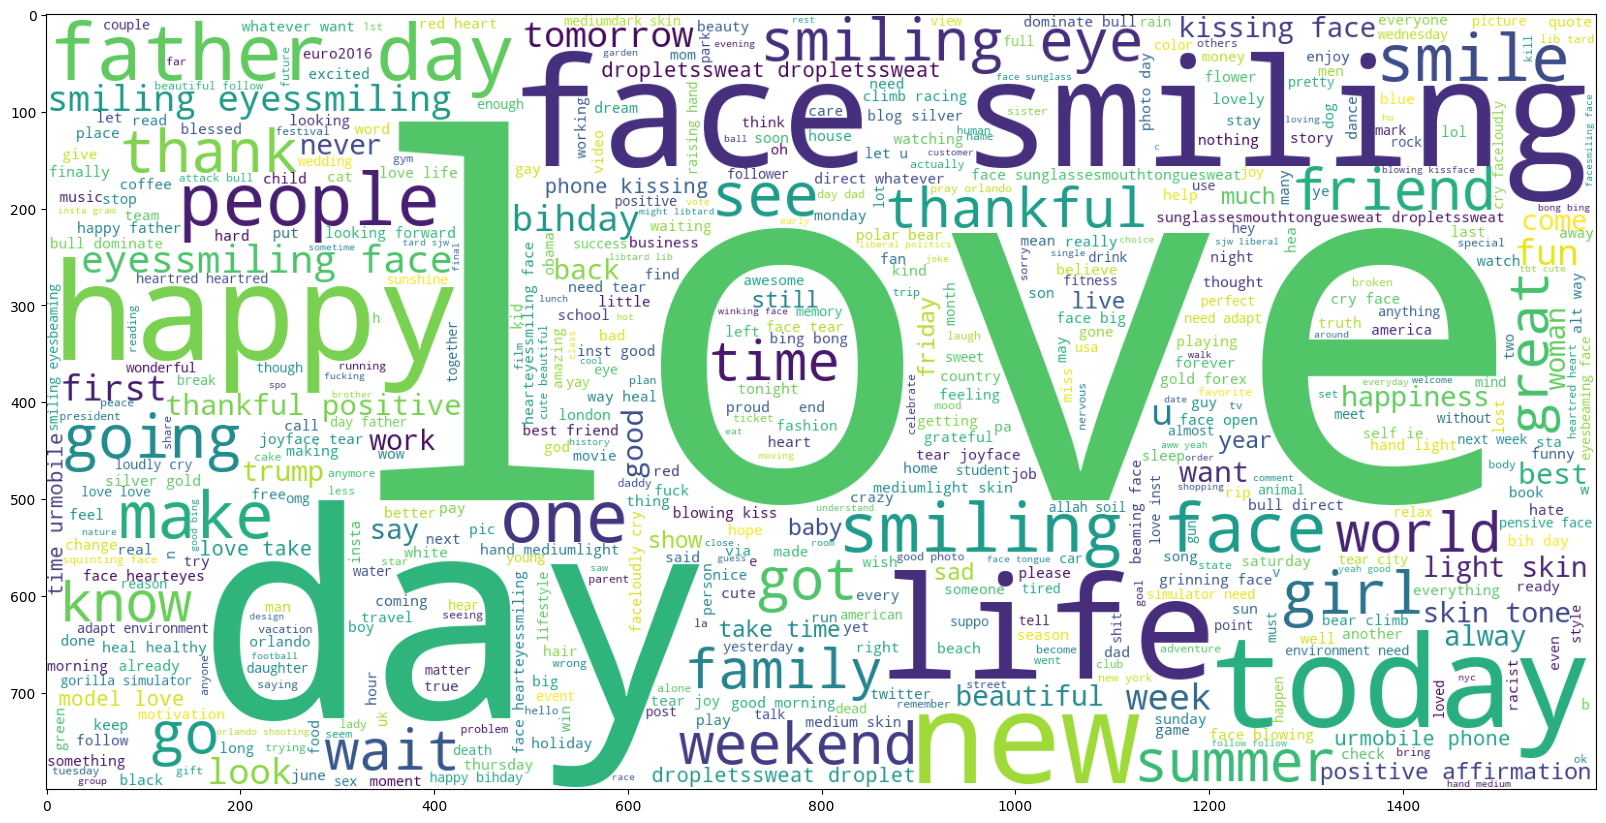

In [210]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(' '.join(df_train['tweet']))

plt.imshow(wc)

#### Changing it to vectors

In [214]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['tweet'])
X_test = vectorizer.transform(df_test['tweet'])

# Extract labels
y_train = train_df['label']
y_test = test_df['label']

**You  are doing Great so far!**

### Modelling

#### Extra: use scikit-learn pipline

##### link: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Using pipelines in scikit-learn promotes better code organization, reproducibility, and efficiency in machine learning workflows.

#### Example usage:

In [216]:
from sklearn.pipeline import Pipeline

model = LogisticRegression()
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', vectorizer),
    ('model', model),
])

# Now you can use the pipeline for training and prediction
# pipeline.fit(X_train, y_train)
# pipeline.predict(X_test)

### Implementing Logestic Regression Model

In [217]:
# Initialize Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)


logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)


# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8797
           1       0.60      0.78      0.68       664

    accuracy                           0.95      9461
   macro avg       0.79      0.87      0.83      9461
weighted avg       0.96      0.95      0.95      9461

Confusion Matrix:
[[8450  347]
 [ 145  519]]


### Implementing Random Forest Classifier Model

In [218]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,           
    random_state=42,            
    class_weight='balanced',    
    n_jobs=-1                   
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Generate classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Generate confusion matrix
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8797
           1       0.73      0.53      0.61       664

    accuracy                           0.95      9461
   macro avg       0.85      0.76      0.79      9461
weighted avg       0.95      0.95      0.95      9461

Confusion Matrix for Random Forest:
[[8666  131]
 [ 313  351]]


### Implementing XGBoost Classifier Model

In [219]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    n_estimators=100,         
    max_depth=20,
    class_weight='balanced'          
)

# Fit the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8797
           1       0.85      0.52      0.64       664

    accuracy                           0.96      9461
   macro avg       0.91      0.75      0.81      9461
weighted avg       0.96      0.96      0.95      9461

Confusion Matrix for XGBoost:
[[8737   60]
 [ 322  342]]


## Edited new TextPreprocessor class to handle the required Pipeline

## Pipeline Approach

In [220]:
from tqdm import tqdm
tqdm.pandas()
class TextPreprocessor_Pipeline(BaseEstimator, TransformerMixin):
    def __init__(self, text_column='tweet', remove_stopwords=True, lemmatize=True):
        self.text_column = text_column
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        
        # Initialize components
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        load()  # Initialize wordsegment data
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if text_column exists
        if self.text_column not in X.columns:
            raise ValueError(f"Column '{self.text_column}' not found in input DataFrame.")
        
       # Apply preprocessing and return only the processed text column
        return X[self.text_column].astype(str).progress_apply(self.preprocess_text)
    
    def preprocess_text(self, text):
        text = self.fix_encoding(text)
        text = self.demojize_text(text)
        text = self.remove_mentions_and_urls(text)
        text = self.lowercase_text(text)
        text = self.split_hashtags(text)
        text = self.expand_contractions(text)
        text = self.remove_punctuation(text)
        text = self.remove_stopwords_and_lemmatize(text)
        return text
    
    def fix_encoding(self, text):
        return fix_text(text)
    
    def demojize_text(self, text):
        text = emoji.demojize(text)
        text = text.replace(":", "").replace("_", " ")
        return text
    
    def remove_mentions_and_urls(self, text):
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        text = re.sub(r'http\S+|www\S+|https\S+|…', '', text)  # Remove URLs and ellipses
        return text
    
    def lowercase_text(self, text):
        return text.lower()
    
    def split_hashtags(self, text):
        hashtags = re.findall(r'#\w+', text)
        for tag in hashtags:
            tag_clean = tag[1:]  # Remove '#' symbol
            # Use wordsegment to split the hashtag
            split_words = segment(tag_clean)
            split_words = ' '.join(split_words)
            text = text.replace(tag, split_words)
        return text
    
    def expand_contractions(self, text):
        return contractions.fix(text)
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def remove_stopwords_and_lemmatize(self, text):
        words = word_tokenize(text)
        if self.remove_stopwords:
            words = [word for word in words if word not in self.stop_words]
        if self.lemmatize:
            words = [self.lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)


### Sets used through out the pipelines

In [221]:
from sklearn.pipeline import Pipeline
# Setting training and testing sets
X_train = train_df[['tweet']]
X_test = test_df[['tweet']] 

y_train = train_df['label']
y_test = test_df['label']


## Random Forest Pipeline

In [222]:
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor_Pipeline()),
    ('vectorizing', vectorizer),  # Ensure consistent casing
    ('model', rf_model),
])

pipeline.fit(X_train, y_train) 

y_pred_rf_model = pipeline.predict(X_test)  


100%|██████████| 9461/9461 [00:10<00:00, 905.13it/s] 


## Logistic Regression Pipeline

In [223]:
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor_Pipeline()),
    ('Vectorizing', vectorizer),
    ('model', logreg_model),
])


pipeline.fit(X_train, y_train)

y_pred_logreg_model = pipeline.predict(X_test) 

100%|██████████| 9461/9461 [00:10<00:00, 936.69it/s] 


## XGBoost Classifier Pipeline

In [224]:
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor_Pipeline()),
    ('Vectorizing', vectorizer),
    ('model', xgb_model),
])


pipeline.fit(X_train, y_train)

y_pred_xgb_model = pipeline.predict(X_test) 

100%|██████████| 9461/9461 [00:11<00:00, 838.64it/s] 


#### Evaluation

**Evaluation metric:**
macro f1 score

Macro F1 score is a useful metric in scenarios where you want to evaluate the overall performance of a multi-class classification model, **particularly when the classes are imbalanced**

![Calculation](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/639c3d934e82c1195cdf3c60_macro-f1.webp)

### Random Forest Results

In [225]:
print(y_pred_rf_model[:5])

# Generate classification report
print("Classification Report for Pipeline:")
print(classification_report(y_test, y_pred_rf_model))

# Generate confusion matrix
print("Confusion Matrix for Pipeline:")
print(confusion_matrix(y_test, y_pred_rf_model))

[0 0 0 0 1]
Classification Report for Pipeline:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8797
           1       0.73      0.53      0.61       664

    accuracy                           0.95      9461
   macro avg       0.85      0.76      0.79      9461
weighted avg       0.95      0.95      0.95      9461

Confusion Matrix for Pipeline:
[[8666  131]
 [ 313  351]]


### Logistic Regression Results

In [226]:
print(y_pred_logreg_model[:5])


# Generate classification report
print("Classification Report for Pipeline:")
print(classification_report(y_test, y_pred_logreg_model))

# Generate confusion matrix
print("Confusion Matrix for Pipeline:")
print(confusion_matrix(y_test, y_pred_logreg_model))

[0 0 0 0 1]
Classification Report for Pipeline:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8797
           1       0.60      0.78      0.68       664

    accuracy                           0.95      9461
   macro avg       0.79      0.87      0.83      9461
weighted avg       0.96      0.95      0.95      9461

Confusion Matrix for Pipeline:
[[8450  347]
 [ 145  519]]


### XGBoost Classifier Results

In [227]:
print(y_pred_xgb_model[:5])

# Generate classification report
print("Classification Report for Pipeline:")
print(classification_report(y_test, y_pred_xgb_model))

# Generate confusion matrix
print("Confusion Matrix for Pipeline:")
print(confusion_matrix(y_test, y_pred_xgb_model))

[0 0 0 0 1]
Classification Report for Pipeline:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8797
           1       0.85      0.52      0.64       664

    accuracy                           0.96      9461
   macro avg       0.91      0.75      0.81      9461
weighted avg       0.96      0.96      0.95      9461

Confusion Matrix for Pipeline:
[[8737   60]
 [ 322  342]]


### Enhancement

- Using different text representation or modeling techniques
- Hyperparameter tuning

In [228]:
# Setting training and testing sets
X_train = train_df[['tweet']]
X_test = test_df[['tweet']] 

y_train = train_df['label']
y_test = test_df['label']

### Setting Logistic Regression Hyperparameter Tuning

In [ ]:
# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',  # Focus on F1-score for imbalance
    cv=5,          
    n_jobs=-1,     
    verbose=2
)

# Fit GridSearchCV
grid_search_logreg.fit(X_train, y_train)

# Retrieve the best parameters and best estimator
best_params_logreg = grid_search_logreg.best_params_
best_model_logreg = grid_search_logreg.best_estimator_

print("Best Hyperparameters for Logistic Regression:")
print(best_params_logreg)

# Make predictions on the test set
y_pred_logreg = best_model_logreg.predict(X_test)

# Evaluate the model
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters for Logistic Regression:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8797
           1       0.66      0.73      0.69       664

    accuracy                           0.95      9461
   macro avg       0.82      0.85      0.83      9461
weighted avg       0.96      0.95      0.96      9461

Confusion Matrix for Logistic Regression:
[[8545  252]
 [ 177  487]]


### Setting Random Forest Hyperparameter Tuning

In [171]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)


# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    # 'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Retrieve the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print("Best Hyperparameters for Random Forest:")
print(best_params_rf)

# Make predictions on the test set
y_pred_rf = best_model_rf.predict(X_test)

# Evaluate the model
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8797
           1       0.62      0.73      0.67       664

    accuracy                           0.95      9461
   macro avg       0.80      0.85      0.82      9461
weighted avg       0.95      0.95      0.95      9461

Confusion Matrix for Random Forest:
[[8504  293]
 [ 177  487]]


### Setting XGBoost Classifier Hyperparameter Tuning

In [174]:
# Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    eval_metric='auc',
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'learning_rate': [0.1, 0.2]
}

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Retrieve the best parameters and best estimator
best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

print("Best Hyperparameters for XGBoost:")
print(best_params_xgb)

# Make predictions on the test set
y_pred_xgb = best_model_xgb.predict(X_test)

# Evaluate the model
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters for XGBoost:
{'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 100}

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      8797
           1       0.88      0.50      0.64       664

    accuracy                           0.96      9461
   macro avg       0.92      0.75      0.81      9461
weighted avg       0.96      0.96      0.95      9461

Confusion Matrix for XGBoost:
[[8750   47]
 [ 333  331]]


### Conclusion and final results


## **Check the readme file**

#### Done!